# Preprocessat Mèdic per Segmentació Mamogràfica
## Taula Final - Preservació Màxima de Qualitat

| **Step**                              | **Purpose**                                       | **Typical Method**                                                       |
| ------------------------------------- | ------------------------------------------------- | ------------------------------------------------------------------------ |
| **1. Denoising**                      | Remove salt-and-pepper noise                      | Median filtering (e.g., `cv2.medianBlur(image, ksize=3)`)                |
| **2. Label removal**                  | Eliminate white text/artifacts on dark background | Threshold upper corners (ROI + Otsu) and remove connected bright regions |
| **3. Resize & Border cropping**                | Resize & remove white borders  | Detect nonzero rows/columns and crop image accordingly                   |
| **4. Contrast adjustment (CHALE)** | Enhance tissue-background separability            | Using local rehistogramization                                        |


In [6]:
# IMPORTS
import cv2
import numpy as np
from pathlib import Path
from typing import Tuple
import matplotlib.pyplot as plt


# CONSTANTS
IMAGE_FOLDER_PATH: str = "../data/test/images"
PREPROCESSED_IMAGE_FOLDER_PATH: str = "../data/test/inputs"

In [7]:
# ========== FUNCIONS INDIVIDUALS DE PREPROCESSAT ==========

def eliminacio_salipebre(imatge: np.ndarray) -> np.ndarray:
    """
    Elimina soroll sal i pebre utilitzant un filtre medià.
    
    Args:
        imatge: Imatge d'entrada en escala de grisos
        
    Returns:
        Imatge processada sense soroll sal i pebre
    """
    return cv2.medianBlur(imatge, 3)  # Filtre medià amb nucli de 3x3


def estandarditzar_orientacio(imatge: np.ndarray) -> np.ndarray:
    """
    Estandarditza l'orientació anatòmica flipant horitzontalment per situar 
    la mama sempre al mateix costat. En aquest cas, el pit esquerre sempre a l'esquerra.
    
    Args:
        imatge: Imatge d'entrada en escala de grisos
        
    Returns:
        Imatge amb orientació estandarditzada
    """
    h: int
    w: int
    h, w = imatge.shape

    # Calcula el llindar Otsu per detectar teixit
    thresh: float = cv2.threshold(imatge, 0, 255, cv2.THRESH_OTSU)[0]

    # Compta píxels de teixit a l'esquerra i dreta
    teixit_esquerra: int = np.sum(imatge[:, :w//2] > thresh)
    teixit_dreta: int = np.sum(imatge[:, w//2:] > thresh)

    # Si hi ha més teixit a la dreta, gira horitzontalment la imatge
    return cv2.flip(imatge, 1) if teixit_esquerra < teixit_dreta else imatge


def eliminar_artefactes(imatge: np.ndarray) -> np.ndarray:
    """
    Elimina artefactes textuals i marques evidents mantenint només el teixit. 
    Ho fa mitjançant un filtre de desenfocament i una màscara de fons. 
    Utilitzant la funció inpaint de OpenCV per pintar l'etiqueta.
    
    Args:
        imatge: Imatge d'entrada en escala de grisos
        
    Returns:
        Imatge sense artefactes textuals
    """

    # Primer, eliminar marges superiors i drets
    imatge = imatge[20:-15, 0:-10]
    
    # Desenfocar lleugerament la imatge i detectar fons (àrees fosques) amb llindar
    blur_img: np.ndarray = cv2.GaussianBlur(imatge, (5, 5), 0)
    tissue_mask: np.ndarray
    _, tissue_mask = cv2.threshold(blur_img, 11, 255, cv2.THRESH_BINARY)
    
    # Aplicar obertura morfològica seguida de tancament per separar components i omplir espais
    kernel: np.ndarray = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    tissue_mask = cv2.morphologyEx(tissue_mask, cv2.MORPH_OPEN, kernel, iterations=12)
    tissue_mask = cv2.morphologyEx(tissue_mask, cv2.MORPH_CLOSE, kernel, iterations=7)

    
    # Mantenir el component connectat més gran (el teixit)
    num_labels: int
    labels: np.ndarray
    stats: np.ndarray
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(tissue_mask, connectivity=8)
    largest_label: int = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Saltar etiqueta de fons
    
    tissue_mask = np.zeros_like(imatge)
    tissue_mask[labels == largest_label] = 255

    # Dilatar la màscara per assegurar que cobreixi adequadament l'àrea del teixit
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    tissue_mask = cv2.dilate(tissue_mask, kernel, iterations=5)

    # Aplicar inpainting per omplir artefactes amb textura del teixit circumdant
    blur_tissue_mask: np.ndarray = cv2.GaussianBlur(tissue_mask, (27, 27), 15).astype(np.float32) / 255.0
    imatge = (imatge*blur_tissue_mask).astype(np.uint8)

    return imatge



def normalitzar_imatge(imatge: np.ndarray) -> np.ndarray:
    """
    Estandarditza el rang de la imatge a [0, 255] i aplica CLAHE per millorar el contrast.
    
    Args:
        imatge: Imatge d'entrada en escala de grisos
        
    Returns:
        Imatge normalitzada amb contrast millorat
    """
    # Primer normalitzar al rang [0, 255]
    imatge = cv2.normalize(imatge, None, 0, 255, cv2.NORM_MINMAX)
    imatge = imatge.astype(np.uint8)
    
    # Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe: cv2.CLAHE = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
    imatge = clahe.apply(imatge)
    return imatge
    


def redimensionar_imatge(imatge: np.ndarray, mida_objectiu: Tuple[int, int] = (560, 400)) -> np.ndarray:
    """
    Redimensiona a mida objectiu amb padding/crop per la dreta.
    
    Args:
        imatge: Imatge d'entrada
        mida_objectiu: Tupla amb (amplada, alçada) objectiu
        
    Returns:
        Imatge redimensionada
    """
    # Obtenir dimensions
    h: int
    w: int
    h, w = imatge.shape
    target_h: int
    target_w: int
    target_h, target_w = mida_objectiu
    
    # Escalar i redimensionar
    new_w: int = int(w * target_h / h)
    imatge = cv2.resize(imatge, (new_w, target_h), interpolation=cv2.INTER_LANCZOS4)
    
    # Ajustar amplada: crop o padding
    if new_w >= target_w: 
        imatge = imatge[:, :target_w]
    else: 
        imatge = cv2.copyMakeBorder(imatge, 0, 0, 0, target_w-new_w, cv2.BORDER_CONSTANT, value=0)

    return imatge


In [8]:
import matplotlib.pyplot as plt
from typing import Dict

def visualitzar_passos_preprocessat(imatge_original: np.ndarray) -> None:
    """
    Visualitza tots els passos del preprocessat per veure l'evolució de la imatge.
    
    Args:
        imatge_original: Imatge original sense processar
    """
    # Guardar cada pas
    passos: Dict[str, np.ndarray] = {}
    
    # Pas 0: Imatge original
    passos['0. Original'] = imatge_original.copy()
    
    # Pas 1: Eliminació sal i pebre
    imatge: np.ndarray = eliminacio_salipebre(imatge_original)
    passos['1. Eliminació sal/pebre'] = imatge.copy()
    
    # Pas 2: Orientació
    imatge = estandarditzar_orientacio(imatge)
    passos['2. Orientació estandarditzada'] = imatge.copy()
    
    # Pas 3: Eliminació artefactes
    imatge = eliminar_artefactes(imatge)
    passos['3. Eliminació artefactes'] = imatge.copy()

    # Pas 4: Normalització
    imatge = normalitzar_imatge(imatge)
    passos['4. Normalització'] = imatge.copy()
    
    # Pas 5: Redimensionament
    imatge = redimensionar_imatge(imatge, mida_objectiu=(768, 512))
    passos['5. Redimensionament'] = imatge.copy()
    
    
    # Crear plot
    fig: plt.Figure
    axes: np.ndarray
    fig, axes = plt.subplots(2, 3, figsize=(14, 12))
    axes = axes.flatten()
    
    for i, (nom, img) in enumerate(passos.items()):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(nom, fontsize=14, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [9]:
# ========== PREPROCESSAT COMÚ ==========

def preprocessat(imatge: np.ndarray) -> np.ndarray:
    """
    Aplica els passos de preprocessat comuns a les tres tècniques:
    0. Eliminació de soroll sal i pebre
    1. Estandardització d'orientació
    2. Eliminació d'artefactes
    3. Normalització de la imatge
    4. Redimensionament a 768x512
    
    Aquests passos són idèntics per Otsu, K-means i U-Net.
    
    Args:
        imatge: Imatge d'entrada en escala de grisos
        
    Returns:
        Imatge preprocessada llesta per segmentació
    """
    # Pas 0: Eliminació de soroll sal i pebre
    imatge_processada: np.ndarray = eliminacio_salipebre(imatge)
    
    # Pas 1: Orientació anatòmica
    imatge_processada = estandarditzar_orientacio(imatge_processada)
    
    # Pas 2: Eliminació d'artefactes
    imatge_processada = eliminar_artefactes(imatge_processada)

    # Pas 3: Normalització de la imatge
    imatge_processada = normalitzar_imatge(imatge_processada)
    
    # Pas 4: Redimensionament estandarditzat
    imatge_processada = redimensionar_imatge(imatge_processada, mida_objectiu=(768, 512))

    
    return imatge_processada


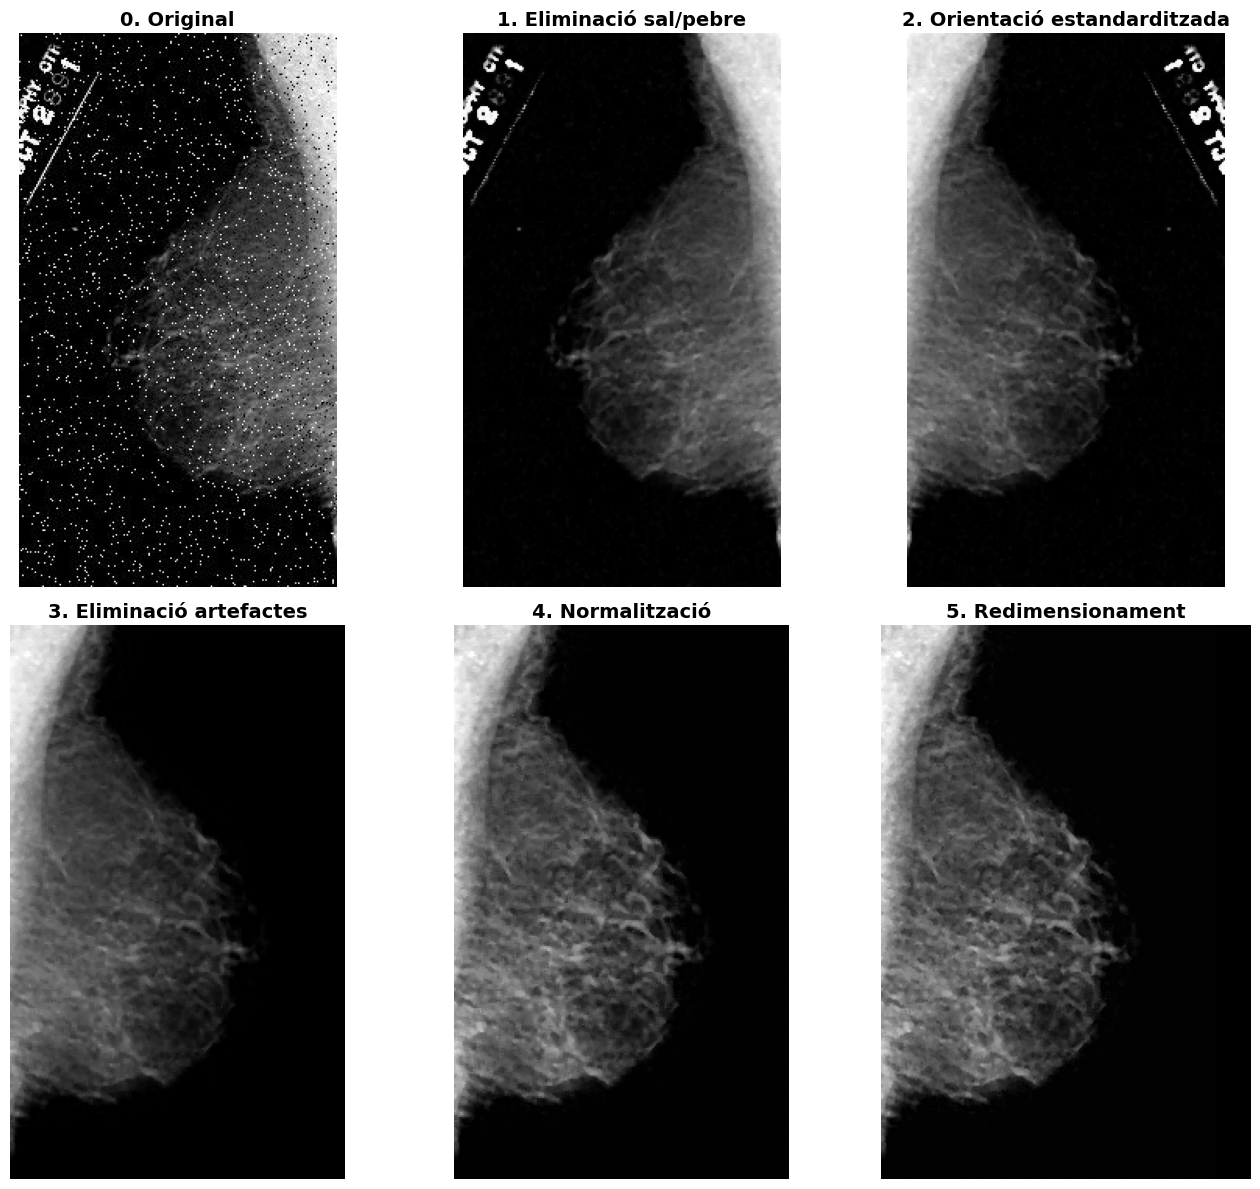

✓ Original_1_b1.jpg


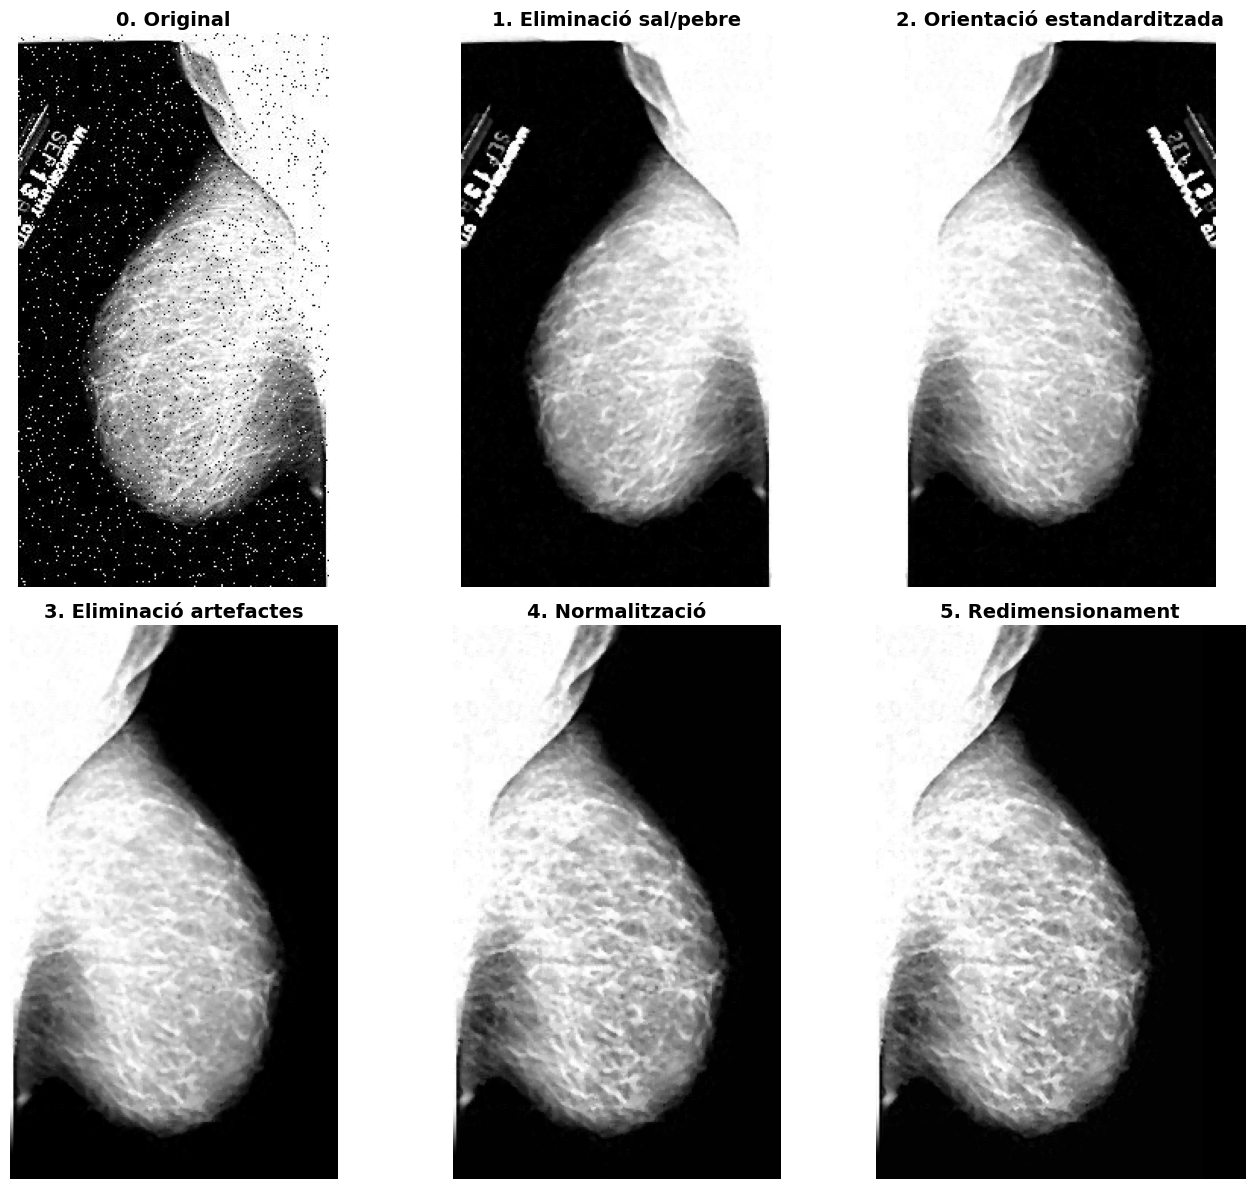

✓ Original_1_b2.jpg


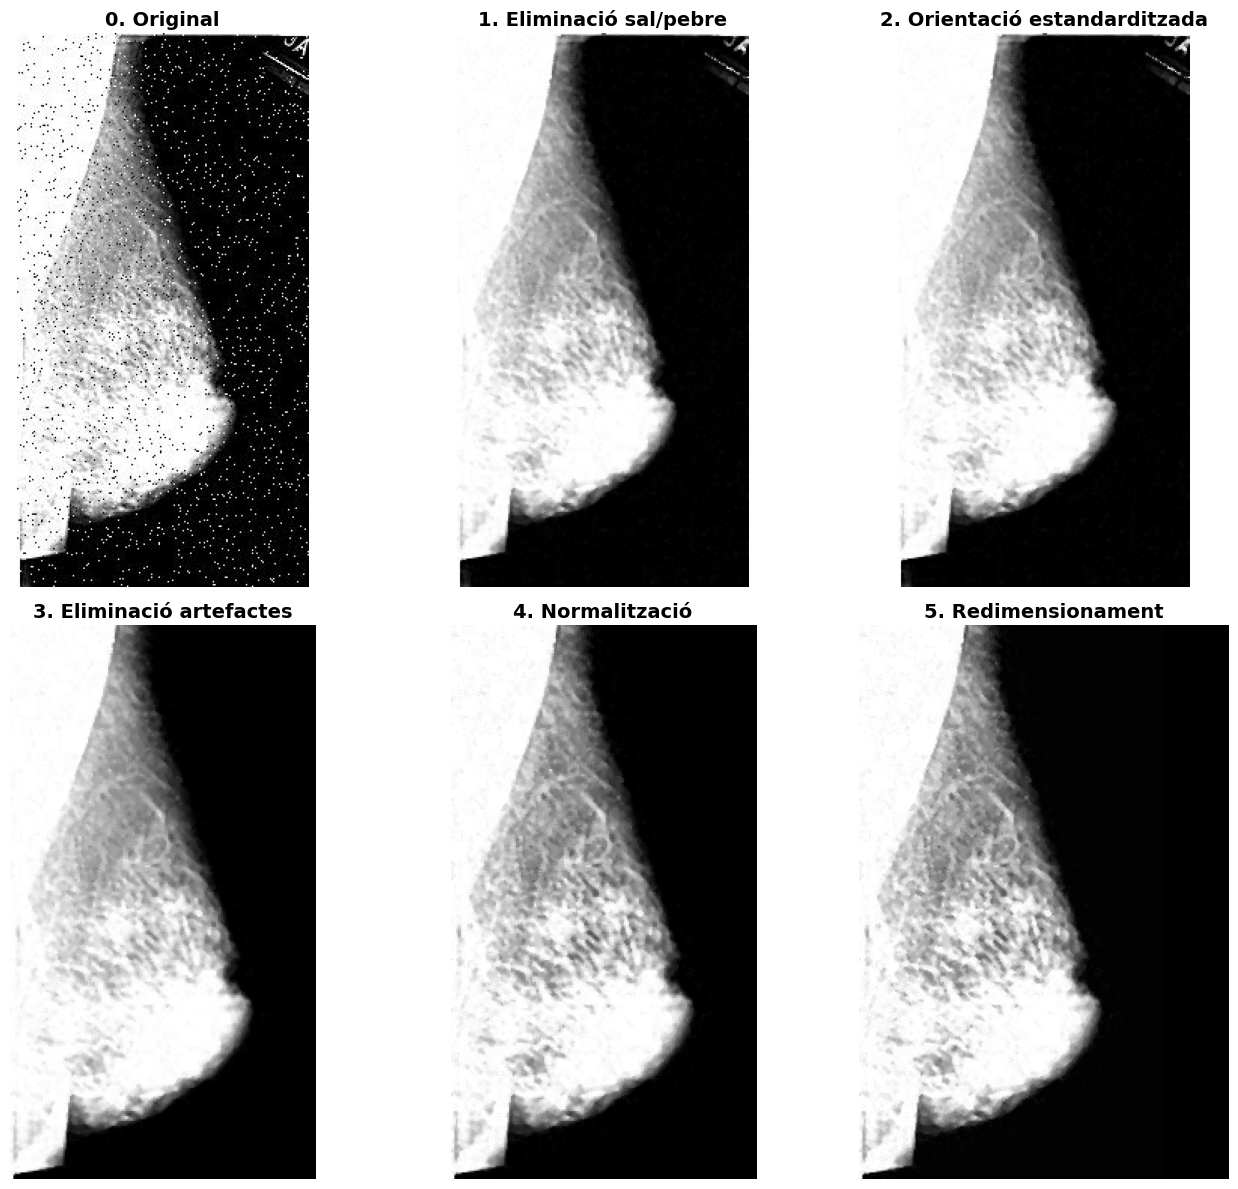

✓ Original_1_b3.jpg


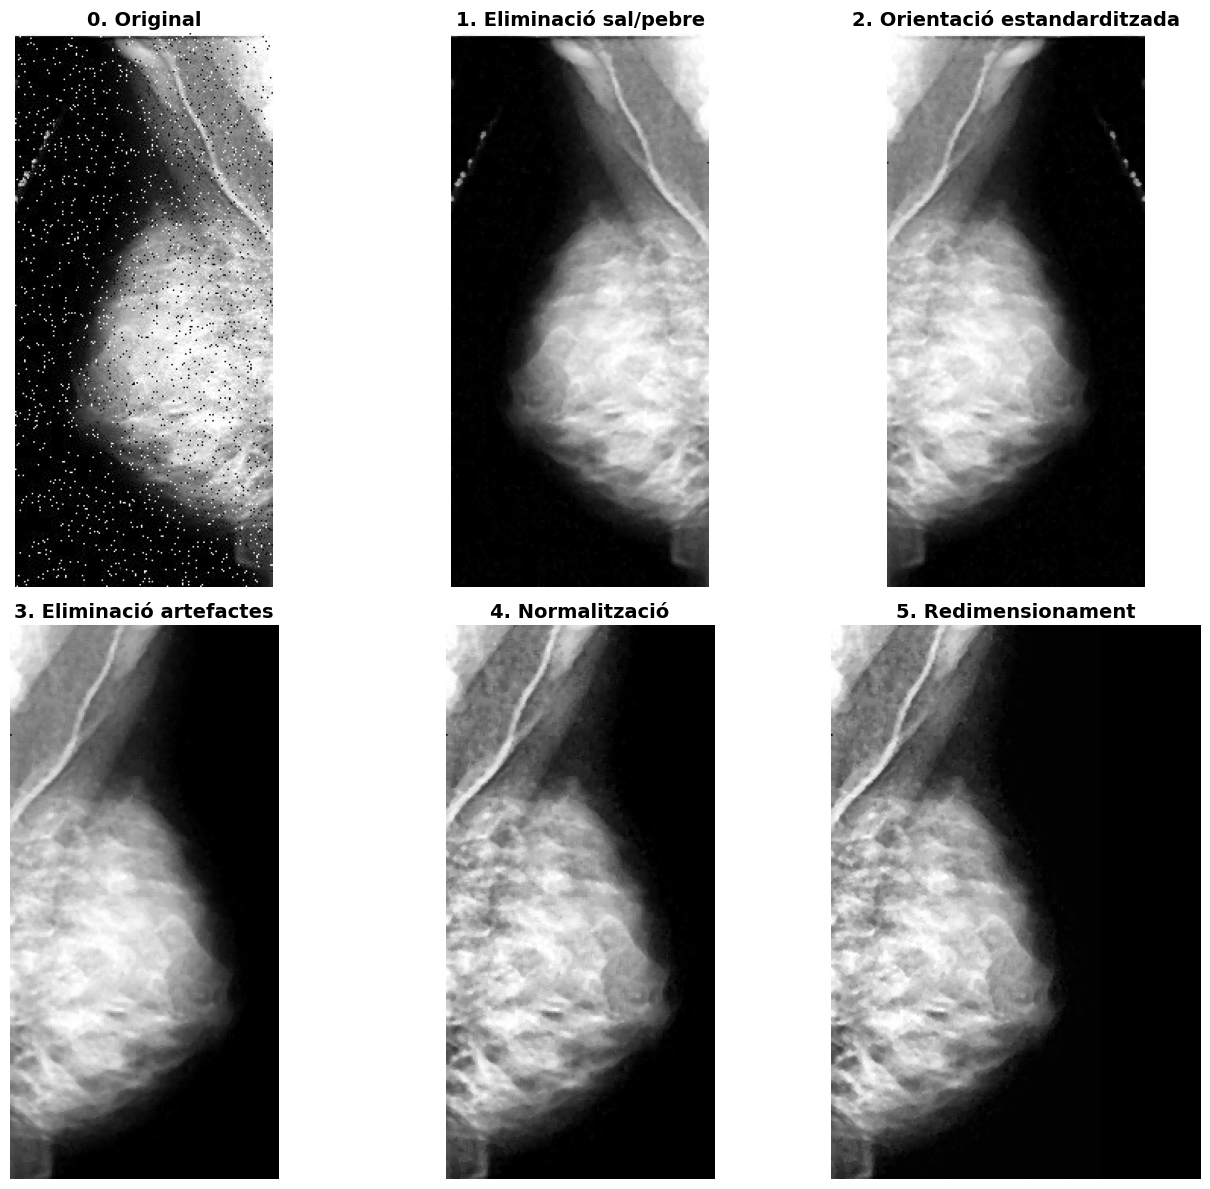

✓ Original_1_b4.jpg


In [10]:
def process_all_images(input_folder: str, output_folder: str) -> None:
    """Processa totes les imatges d'una carpeta d'entrada i les desa en una carpeta de sortida.
    
    Args:
        input_folder: Ruta de la carpeta d'entrada amb imatges
        output_folder: Ruta de la carpeta de sortida per a les imatges processades
    """
    input_path: Path = Path(input_folder)
    output_path: Path = Path(output_folder)


    for img_file in input_path.glob("*"):
        if img_file.suffix.lower() not in {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"}:
            continue
        image: np.ndarray = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"❌ {img_file.name}")
            continue
        visualitzar_passos_preprocessat(image)
        processed: np.ndarray = preprocessat(image)
        save_path: Path = output_path / f"{img_file.stem}_pib.tiff"
        cv2.imwrite(str(save_path), processed)
        print(f"✓ {img_file.name}")


def main() -> None:
    """Funció principal que executa el preprocessament d'imatges."""
    if not Path(IMAGE_FOLDER_PATH).exists():
        print("❌ Carpeta no trobada. Creada.")
        Path(IMAGE_FOLDER_PATH).mkdir(parents=True)
        return
    process_all_images(IMAGE_FOLDER_PATH, PREPROCESSED_IMAGE_FOLDER_PATH)

if __name__ == "__main__":
    main()